# Sampling SigClust

In [1]:
%load_ext autoreload
%autoreload 1

In [3]:
import sigclust

In [4]:
import numpy as np
np.random.seed(824)

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd
from scipy.linalg import sqrtm

In [5]:
toy = pd.read_csv('examples/sigclust_toy_data.csv', header=None)

In [6]:
toy = toy.T
toy.columns = ['label', 'x1', 'x2']

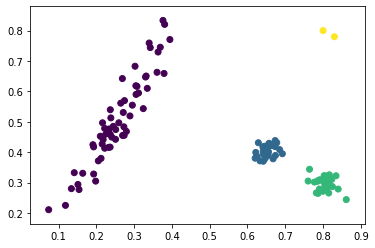

In [7]:
plt.scatter(toy['x1'], toy['x2'], c=toy['label'])

## Conventional SigClust does not split the stretched gaussian from the outliers

In [10]:
longcluster_and_outliers = toy[toy['label'].isin((1,4))]

In [8]:
np.random.seed(824)
sc = sigclust.SigClust()
sc.fit(longcluster_and_outliers[['x1', 'x2']], longcluster_and_outliers['label'])
print("p-value: {} \nz-score: {}".format(sc.p_value, sc.z_score))

p-value: 1.0 
z-score: 6.621304975716945


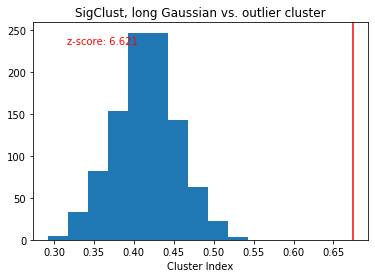

In [9]:
sample_ci = sigclust.compute_cluster_index(longcluster_and_outliers[['x1', 'x2']], longcluster_and_outliers['label'])
plt.hist(sc.simulated_cluster_indices)
plt.axvline(sample_ci, color='red')
plt.title("SigClust, long Gaussian vs. outlier cluster")
plt.xlabel("Cluster Index")
plt.text(.1, .9, "z-score: {:.3f}".format(sc.z_score), color='red', transform=plt.gca().transAxes)
plt.show()

Recall that the sample CI is way to the right because 2-means clustering doesn't actually give the desired split:

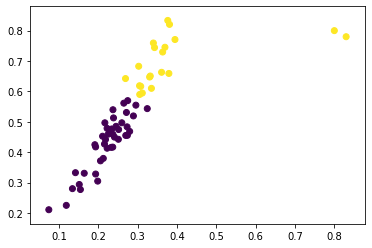

In [10]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(longcluster_and_outliers[['x1', 'x2']])
plt.scatter(longcluster_and_outliers['x1'], longcluster_and_outliers['x2'], c=kmeans.labels_)

What does SigClust do if we use the labels from 2-means?

In [11]:
sc = sigclust.SigClust()
sc.fit(longcluster_and_outliers[['x1', 'x2']], kmeans.labels_)

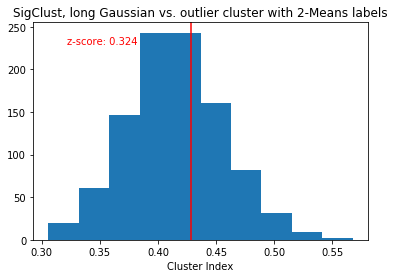

In [12]:
sample_ci = sigclust.compute_cluster_index(longcluster_and_outliers[['x1', 'x2']], kmeans.labels_)
plt.hist(sc.simulated_cluster_indices)
plt.axvline(sample_ci, color='red')
plt.title("SigClust, long Gaussian vs. outlier cluster with 2-Means labels")
plt.xlabel("Cluster Index")
plt.text(.1, .9, "z-score: {:.3f}".format(sc.z_score), color='red', transform=plt.gca().transAxes)
plt.show()

So if we use the 2-means labels, we find that the test does not reject. We do know that the data are not from a single Gaussian, so this is a Type 2 error, i.e. we do not have power in this case.

## We add some more points to the outlier class

In [8]:
stretched_gaussian = toy[toy['label']==1]
outliers = toy[toy['label']==4]

In [9]:
more_outliers = np.random.multivariate_normal(outliers[['x1','x2']].mean(), np.diag([.001,.001]), size=10)
more_outliers = pd.DataFrame(more_outliers, columns=['x1', 'x2'])
more_outliers['label'] = 5
more_outliers.head()

,x1,x2,label
0,0.766303,0.777160,5
1,0.791845,0.835837,5
2,0.815932,0.753530,5
3,0.799430,0.810737,5
4,0.842099,0.858174,5


In [10]:
stretched_gaussian_plus_10_outliers=pd.concat([stretched_gaussian, more_outliers], ignore_index=True)

Finally we plot the stretched gaussian, the original 2 outliers, and the 10 new outliers.

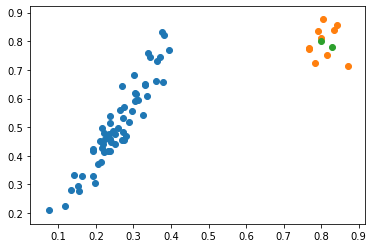

In [11]:
plt.scatter(stretched_gaussian['x1'], stretched_gaussian['x2'])
plt.scatter(more_outliers['x1'], more_outliers['x2'])
plt.scatter(outliers['x1'], outliers['x2'])

In [12]:
def plot_ellipse(ax, data):
    "Plot covariance ellipse of given data to axis"
    mean = data.mean(axis=0).values
    mean = mean.reshape((len(mean), 1))
    cov = np.cov(data.T)
    ncpts = 401 ;
    vangles = np.linspace(0, 2*np.pi, ncpts) # Equally spaced angles
    mucirc = np.vstack([np.cos(vangles), np.sin(vangles)])  # Equally spaced points on unit circle

    muellips = np.tile(mean, ncpts) + 2 * np.diag((1,1)) @ sqrtm(cov) @ mucirc
    ax.plot(muellips[0,:],muellips[1,:],'k-') 


In [18]:
class SamplingSigClustDemo:
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.samples = []
        self.sigclusts = []
        self.sample_cis = []
        self.kmeans_results = []
        class_1, class_2 = sigclust.split_data(self.data, self.labels)
        majority_class, minority_class = sigclust.sort_by_n_desc([class_1, class_2])
        self.majority = majority_class
        self.minority = minority_class
        self.nmin = minority_class.shape[0]
        self.full_kmeans = None
        self.full_ci = None
    
        
    def fit(self):
        for i in range(5):
            majority_sample = self.majority.sample(self.nmin, replace=False)
            sample = pd.concat([majority_sample, self.minority], ignore_index=True)
            self.samples.append(sample)
            newlabels = np.concatenate([np.repeat(1, self.nmin), np.repeat(2, self.nmin)])
            sample_ci = sigclust.compute_cluster_index_given_classes(majority_sample, self.minority)
            self.sample_cis.append(sample_ci)
            sc = sigclust.SigClust(200)
            sc.fit(sample, newlabels)
            self.sigclusts.append(sc)
            
            kmeans = KMeans(n_clusters=2)
            kmeans.fit(sample)
            self.kmeans_results.append(kmeans)
            
        self.full_kmeans = KMeans(n_clusters=2)
        self.full_kmeans.fit(self.data)
        self.full_ci = sigclust.compute_cluster_index(self.data, self.labels)
        
    def plot(self):
        "Plot samples, covariance ellipses, and simulated CIs"
        fig, axes = plt.subplots(3, 6, figsize=(15,8), sharey='row', sharex='row', constrained_layout=True)
        
        for i in range(5):
            # Plot samples and ellipses
            sample = self.samples[i]
            sc = self.sigclusts[i]
            sample_ci = self.sample_cis[i]
            estimated_labels = self.kmeans_results[i].labels_

            axes[0,i].scatter(sample['x1'], sample['x2'], c=estimated_labels)
            plot_ellipse(axes[0,i], sample[['x1','x2']])


            # Plot simulated CIs
            ax = axes[1,i]
            ax.hist(sc.simulated_cluster_indices, density=True)
            ax.axvline(sample_ci, color='red', alpha=.6)
            #ax.axvline(overall_ci, color='green')
            ax.text(.1, .9, "sample z: {:.2f}\nsample CI: {:.2f}".format(sc.z_score, sample_ci), color='darkred', transform=ax.transAxes)

            #ax.text(.1, .5, "overall CI: {:.2f}".format(overall_ci), color='green', transform=ax.transAxes)

        all_simulated_cis = np.concatenate([sc.simulated_cluster_indices for sc in self.sigclusts])
        axes[1,5].hist(all_simulated_cis, density=True)

        # Rightmost plot: all ellipses and CIs
        for i in range(5):
            ax = axes[0,5]
            ax.scatter(self.data['x1'], self.data['x2'], c=self.full_kmeans.labels_)
            plot_ellipse(ax, self.samples[i][['x1','x2']])
            ax = axes[1,5]
            ax.axvline(self.sample_cis[i], color='red', alpha=.6)
            #ax.axvline(overall_ci, color='green')

        # Plot differences
        differences = [sc.simulated_cluster_indices - sample_ci for (sc, sample_ci) in zip(self.sigclusts, self.sample_cis)]
        
        for i in range(5):
            ax = axes[2, i]
            ax.hist(differences[i], density=True)
            ax.axvline(0, color='red', alpha=0.6)

        all_differences = np.concatenate(differences)
        axes[2,5].hist(all_differences, density=True)
        axes[2,5].axvline(0, color='red', alpha=0.6)
        axes[0,5].set_title("All")
        axes[2,0].set_title("Differences:")
        axes[2,5].set_title("Final Diagnostic")

        fig.suptitle('Five Sample Scheme, Colored by 2-Means labels')


    
            
            
    

In [20]:
sscd = SamplingSigClustDemo(stretched_gaussian_plus_10_outliers[['x1', 'x2']], stretched_gaussian_plus_10_outliers['label'])

In [21]:
sscd.fit()

## Sampling SigClust: long gaussian vs. 10 'outliers'

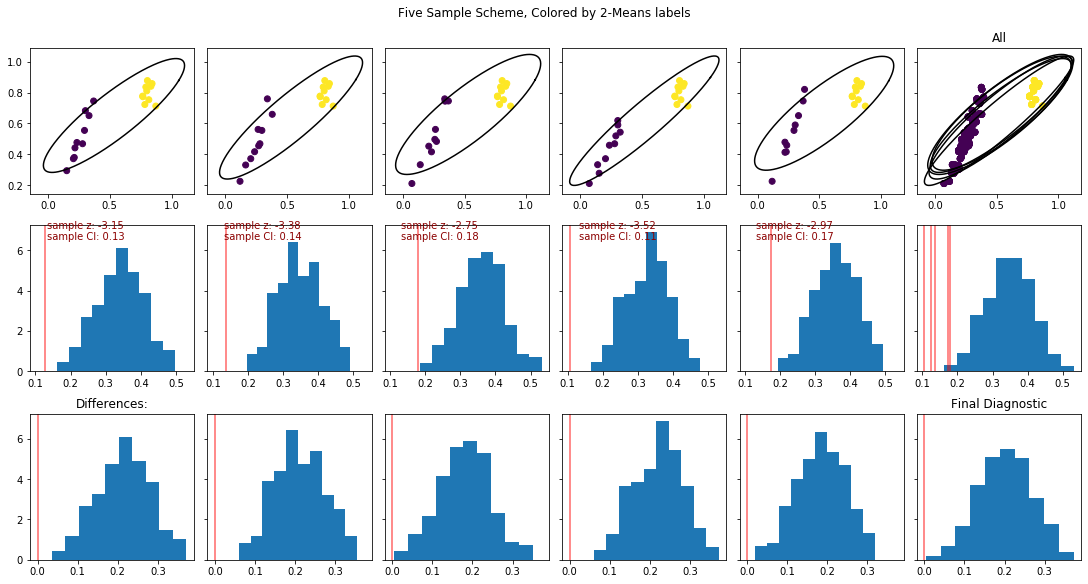

In [22]:
sscd.plot()

In [32]:
sc = sigclust.SigClust()
sc.fit(stretched_gaussian_plus_10_outliers[['x1','x2']], stretched_gaussian_plus_10_outliers['label'])

In [33]:
ssc = sigclust.SamplingSigClust(num_samplings=5, num_simulations_per_sample=200)
ssc.fit(stretched_gaussian_plus_10_outliers[['x1','x2']], stretched_gaussian_plus_10_outliers['label'])

Text(0.5, 1.0, 'Sampling SigClust')

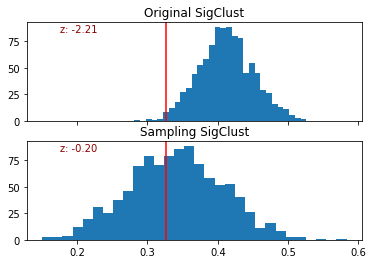

In [34]:
fig, axes = plt.subplots(2,1, sharex=True)
ax = axes[0]
ax.hist(sc.simulated_cluster_indices, bins=30)
sample_ci = sigclust.compute_cluster_index(stretched_gaussian_plus_10_outliers[['x1','x2']], stretched_gaussian_plus_10_outliers['label'])
ax.axvline(sample_ci, color='red')
ax.text(.1, .9, "z: {:.2f}".format(sc.z_score), color='darkred', transform=ax.transAxes)
ax.set_title("Original SigClust")

ax = axes[1]
ax.hist(ssc.simulated_cluster_indices, bins=30)
ax.axvline(sample_ci, color='red')
ax.text(.1, .9, "z: {:.2f}".format(ssc.z_score), color='darkred', transform=ax.transAxes)
ax.set_title("Sampling SigClust")

## Testing this on some other datasets

In [23]:
stretched_gaussian_plus_2_outliers = toy[toy['label'].isin([1,4])]
sscd = SamplingSigClustDemo(stretched_gaussian_plus_2_outliers[['x1','x2']], stretched_gaussian_plus_2_outliers['label'])
sscd.fit()

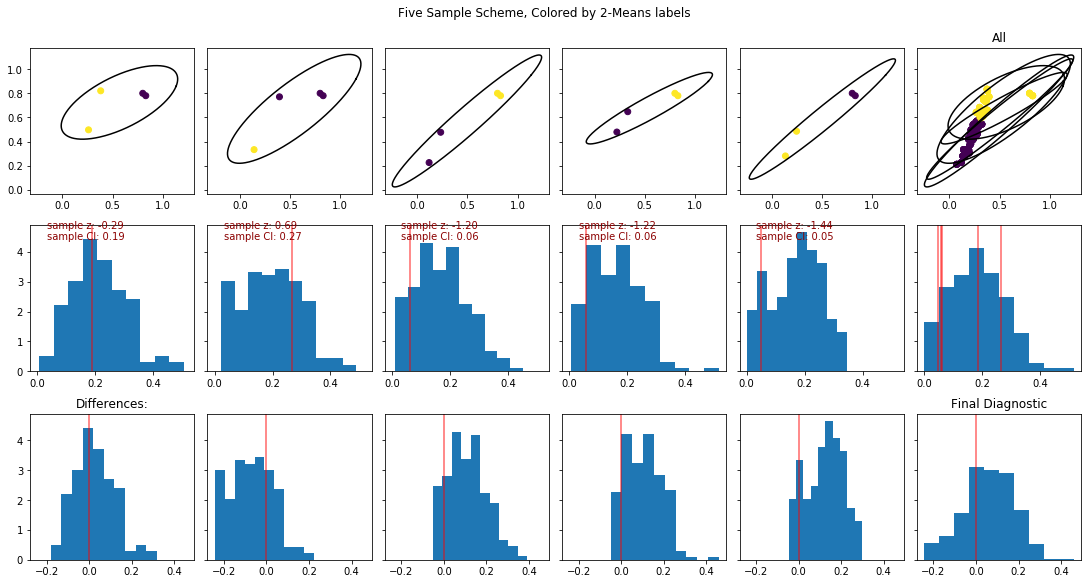

In [24]:
sscd.plot()

## Long gaussian alone

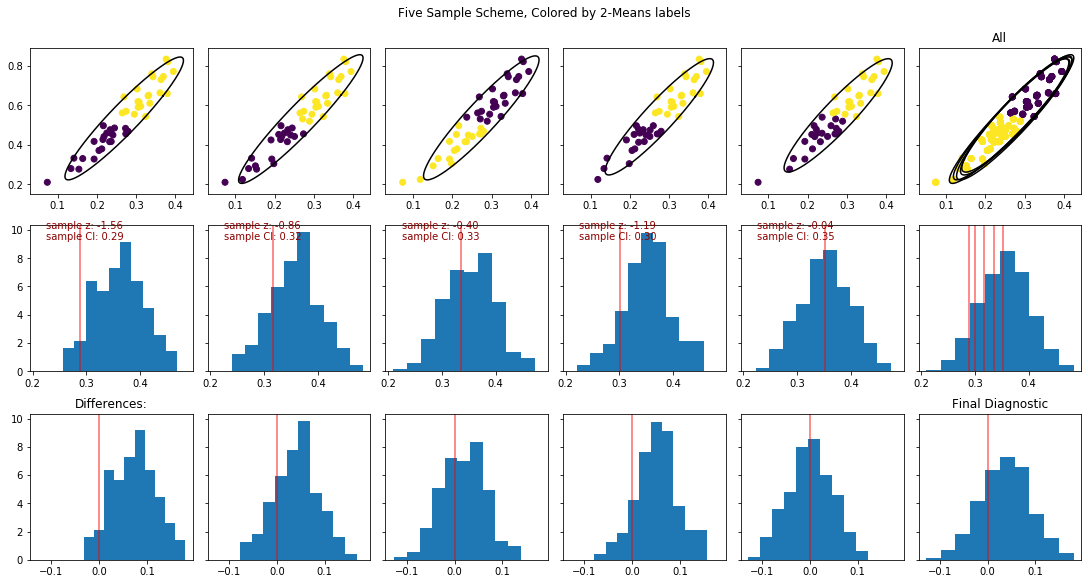

In [27]:
long_gaussian = toy[toy['label']==1]
kmeans = KMeans(n_clusters=2)
kmeans.fit(long_gaussian[['x1','x2']])
sscd = SamplingSigClustDemo(long_gaussian[['x1','x2']], kmeans.labels_)
sscd.fit()
sscd.plot()

## Both spherical clusters

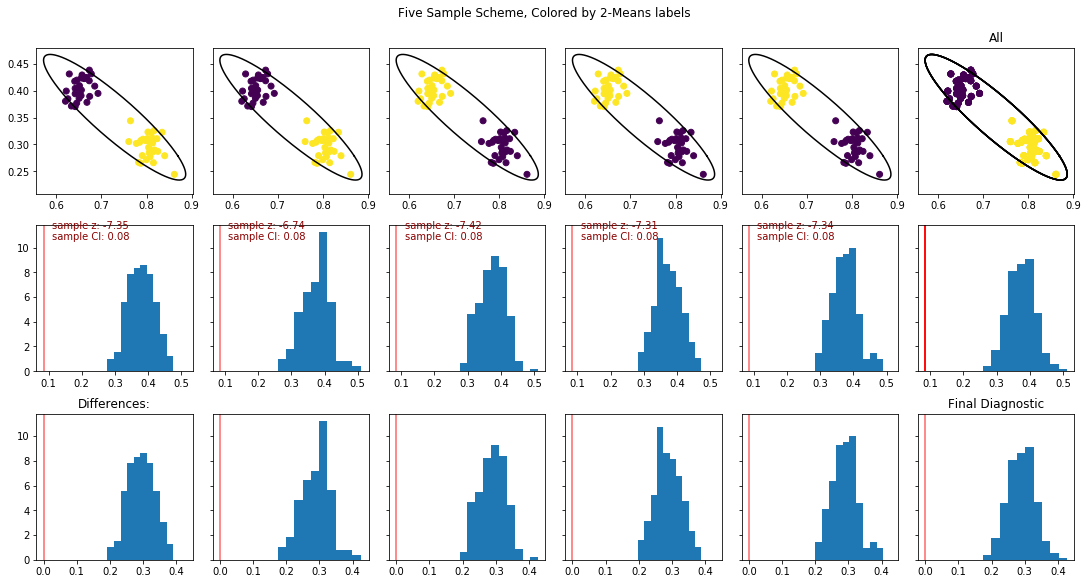

In [29]:
sphericals = toy[toy['label'].isin([2,3])]
sscd = SamplingSigClustDemo(sphericals[['x1','x2']], sphericals['label'])
sscd.fit()
sscd.plot()

## Long gaussian plus one spherical

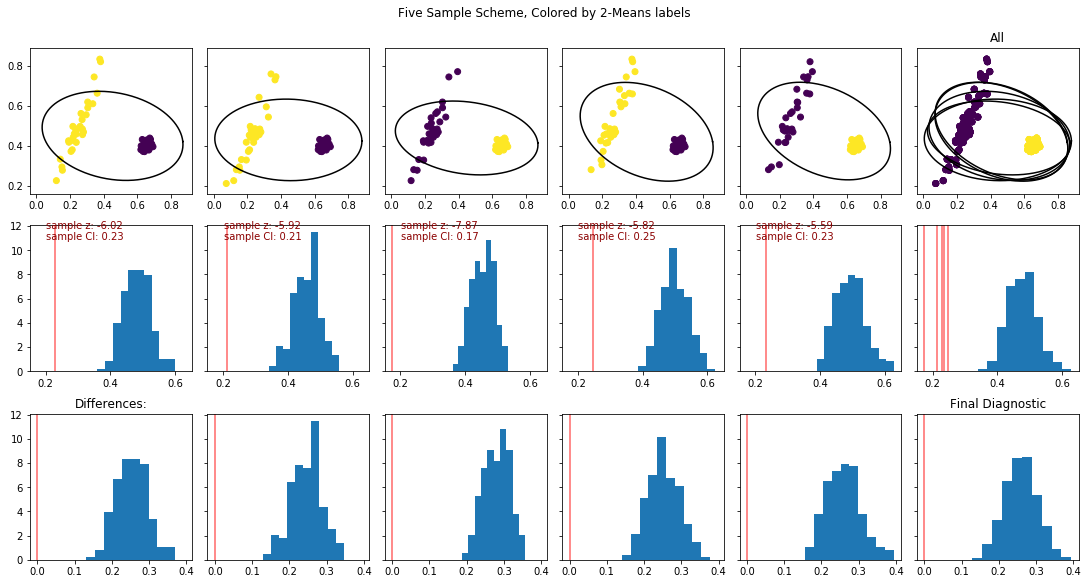

In [31]:
data = toy[toy['label'].isin([1,2])]
sscd = SamplingSigClustDemo(data[['x1','x2']], data['label'])
sscd.fit()
sscd.plot()